# Autoencoder Digit Recognition

In [214]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

import torch
import torch.nn as nn
import torch.optim as optim

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

load data

In [215]:
train_dataset = MNIST(root='../../data',
                train=True,
                download=True,
                transform=ToTensor())

test_data = MNIST(root='../../data',
                train=False,
                download=True,
                transform=ToTensor())

set device

In [216]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Visualize Some Data

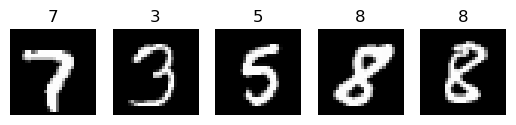

In [217]:
figure = plt.figure()
cols, rows = 5,1

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()

prepare validation dataset

In [218]:
train_data, val_data = random_split(train_dataset,[0.9,0.1])

## Classification Using Autoencoder

### Hyperparameters

In [219]:
learning_rate = 1e-1
batch_size = 64
epochs = 150

training_loss = np.zeros(epochs,dtype=float)
validation_loss = np.zeros(epochs,dtype=float)

### Use Dataloader for to Make Batches

In [220]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

### Load Model

In [221]:
class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=1000),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=500),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=250),
            nn.BatchNorm1d(num_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250,out_features=2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=250),
            nn.BatchNorm1d(num_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=500),
            nn.BatchNorm1d(num_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=1000),
            nn.BatchNorm1d(num_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000,out_features=784),
            nn.Sigmoid(),
            nn.Unflatten(dim=1,unflattened_size=(1,28,28))
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return encoded, decoded

model = Autoencoder()
summary(model, (batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Flatten: 2-1                      [64, 784]                 --
│    └─Linear: 2-2                       [64, 1000]                785,000
│    └─BatchNorm1d: 2-3                  [64, 1000]                2,000
│    └─ReLU: 2-4                         [64, 1000]                --
│    └─Linear: 2-5                       [64, 500]                 500,500
│    └─BatchNorm1d: 2-6                  [64, 500]                 1,000
│    └─ReLU: 2-7                         [64, 500]                 --
│    └─Linear: 2-8                       [64, 250]                 125,250
│    └─BatchNorm1d: 2-9                  [64, 250]                 500
│    └─ReLU: 2-10                        [64, 250]                 --
│    └─Linear: 2-11                      [64, 2]               

In [222]:
model = model.to(device)

### Define Loss and Optimizer

In [223]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### Training Loop

In [224]:
from torch.optim.lr_scheduler import MultiStepLR

scheduler = MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)

In [225]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        encoded, decoded = model(X) 
        loss = loss_fn(X, decoded) #use decoder output to calculate loss with encoder input

        #backpropogation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss 
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    scheduler.step()

    train_loss /= num_batches

    print(f"Training Error: \n Avg loss: {train_loss:>8f}")

    return train_loss

### Validation Loop

In [226]:
def validate(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    val_loss= 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            encoded, decoded = model(X)
            loss = loss_fn(decoded, X)

            val_loss += loss

    
    val_loss /= num_batches
    
    print(f"Validation Error: \n Avg loss: {val_loss:>8f}")

    return val_loss

## Training

In [227]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss[t] = train(train_dataloader, model, loss_fn, optimizer, device).item()
    validation_loss[t] = validate(val_dataloader, model, loss_fn, device).item()

print("Done!")

Epoch 1
-------------------------------
loss: 0.239845  [   64/60000]
loss: 0.175245  [ 6464/60000]
loss: 0.133826  [12864/60000]
loss: 0.108687  [19264/60000]
loss: 0.093313  [25664/60000]
loss: 0.085220  [32064/60000]
loss: 0.075770  [38464/60000]
loss: 0.075633  [44864/60000]
loss: 0.071858  [51264/60000]
loss: 0.067044  [57664/60000]
Training Error: 
 Avg loss: 0.106069
Validation Error: 
 Avg loss: 0.068699
Epoch 2
-------------------------------
loss: 0.066913  [   64/60000]
loss: 0.065265  [ 6464/60000]
loss: 0.064045  [12864/60000]
loss: 0.062602  [19264/60000]
loss: 0.063212  [25664/60000]
loss: 0.065798  [32064/60000]
loss: 0.060553  [38464/60000]
loss: 0.061659  [44864/60000]
loss: 0.059868  [51264/60000]
loss: 0.058348  [57664/60000]
Training Error: 
 Avg loss: 0.062804
Validation Error: 
 Avg loss: 0.059541
Epoch 3
-------------------------------
loss: 0.056662  [   64/60000]
loss: 0.059297  [ 6464/60000]
loss: 0.058271  [12864/60000]
loss: 0.059095  [19264/60000]
loss: 0.

### Learning Curve

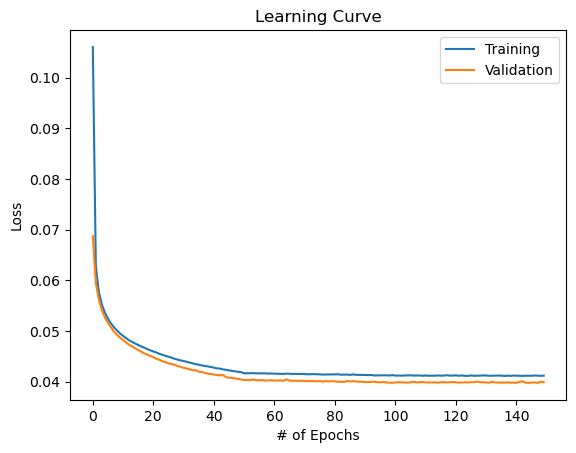

In [228]:
plt.plot(training_loss)
plt.plot(validation_loss)

plt.legend(['Training','Validation'])
plt.title("Learning Curve")
plt.ylabel("Loss")
plt.xlabel("# of Epochs")

plt.show()

In [229]:
np.save('training_loss.npy', training_loss)
np.save('validation_loss.npy', validation_loss)

In [230]:
torch.save(model.state_dict(), "autoencoder-weights.pt")

### Test Loop

In [231]:
model = Autoencoder().to(device)
model.load_state_dict(torch.load("autoencoder-weights.pt", weights_only=True))

<All keys matched successfully>

In [232]:
latentSpace = np.zeros(shape=(len(test_data),3))

In [233]:
test_dataloader = DataLoader(dataset=test_data)

In [234]:
def test(dataloader, model, device, history):
    model.eval()

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            encoded, decoded = model(X)
            history[i][0], history[i][1] = encoded[0][0].item(), encoded[0][1].item()
            history[i][2] = y.item()

In [235]:
test(test_dataloader, model, device, latentSpace)

In [236]:
import pandas as pd
import seaborn as sns

In [237]:
df = pd.DataFrame(latentSpace, columns=["PC1","PC2","digit"])

In [241]:
df.to_csv("full_data.csv",index=False)

In [238]:
df_filtered = df.groupby('digit').head(500)

In [242]:
df_filtered.to_csv("data.csv",index=False)

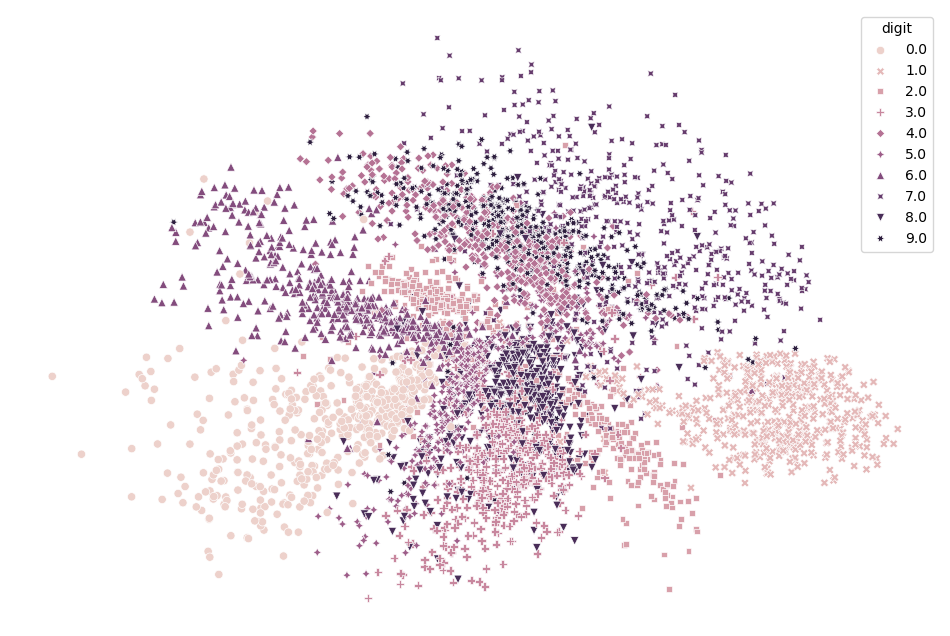

In [239]:
plt.figure(figsize=(12, 8))

cmap = plt.get_cmap('tab10')
fig = sns.scatterplot(data=df_filtered,x='PC1',y='PC2',hue='digit',style='digit', legend='full')


fig.tick_params(bottom=False, left=False)
fig.set(xticklabels=[],
        xlabel=None,
        yticklabels=[],
        ylabel=None)
fig.set_frame_on(False)
display()

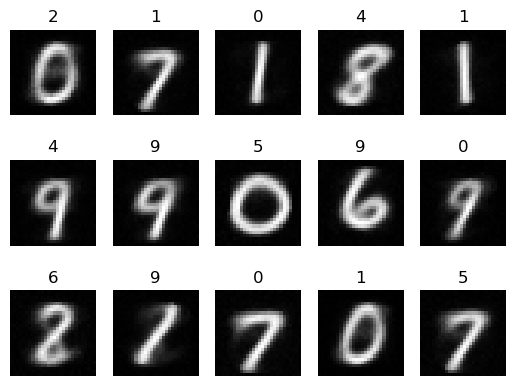

In [240]:
model.eval()

figure = plt.figure()
cols, rows = 5,3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    x, y = test_data[sample_idx][0], test_data[i][1]

    with torch.no_grad():
        x = x.to(device)
        latent_space, pred = model(x)

    figure.add_subplot(rows, cols, i)
    plt.title(y)
    plt.axis("off")
    plt.imshow(pred.cpu().squeeze(), cmap="gray")
    
plt.show()